In [1]:
import pandas as pd
import csv

In [6]:
dataset = pd.read_csv('dataset_da_allenamento.csv', sep=";")

In [8]:
dataset.drop(columns='Unnamed: 0', inplace=True)
dataset.replace('5+', 6, inplace = True)
dataset.replace('3+', 4, inplace = True)
dataset = dataset[dataset.Prezzo != 'Affitto\n                                                                                    750/mese\n                                        ']
dataset = dataset[dataset.Prezzo != 'Affitto\n                                                                                    500/mese\n                                        ']
dataset = dataset[dataset.Locali != 'C']
dataset = dataset[dataset.Prezzo != 'prezzo su richiesta']
dataset = dataset[dataset.Superficie != '250, terreno di proprietà 2.000']
dataset = dataset[dataset.Superficie != '100, terreno di proprietà 200']
dataset = dataset[dataset.Superficie != '160, terreno di proprietà 400']
dataset = dataset[dataset.Superficie != '165, terreno di proprietà 450']
dataset = dataset[dataset.Superficie != '105, terreno di proprietà 100']
dataset = dataset[dataset.Superficie != '130, terreno di proprietà 180']

In [9]:
dataset.fillna(value=0, inplace=True)

In [10]:
dataset.to_csv('dataset_pre_allenamento.csv', sep=';')

In [39]:
dataset = dataset.merge(pd.get_dummies(dataset['Zona']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Piano']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Contratto']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Tipologia']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Tipo proprietà']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Anno di costruzione']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Stato']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Riscaldamento']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Climatizzatore']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Classe energetica']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Arredato S/N']), left_index=True, right_index=True)

dataset.drop(columns='Zona', inplace=True)
dataset.drop(columns='Piano_x', inplace=True)
dataset.drop(columns='Contratto', inplace=True)
dataset.drop(columns='Tipologia', inplace=True)
dataset.drop(columns='Tipo proprietà', inplace=True)
dataset.drop(columns='Anno di costruzione', inplace=True)
dataset.drop(columns='Stato', inplace=True)
dataset.drop(columns='Riscaldamento', inplace=True)
dataset.drop(columns='Climatizzatore', inplace=True)
dataset.drop(columns='Classe energetica', inplace=True)
dataset.drop(columns='Arredato S/N', inplace=True)

dataset.fillna(0,inplace=True)

In [40]:
dataset['Prezzo'] = dataset['Prezzo'].astype(int)
dataset['Superficie'] = dataset['Superficie'].astype(int)
dataset['Locali'] = dataset['Locali'].astype(int)
#dataset['Price'] = (dataset['Prezzo'].astype(int) + dataset['Spese condominio'].astype(int) + dataset['Spese riscaldamento'].astype(int))
dataset.drop(columns= ['Spese condominio', 'Spese riscaldamento'], inplace=True)

In [41]:
dataset = dataset[dataset['Prezzo']<1000]
indirizzi = dataset['Link annuncio']
dataset.drop(columns= ['Link annuncio'], inplace=True)

In [42]:
target = dataset['Prezzo']
data = dataset.drop(columns= ['Prezzo'])

In [55]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.values, target.values,
                                                    train_size=0.75, test_size=0.25)

tpot = TPOTRegressor(generations=50, population_size=20, verbosity=2, max_eval_time_mins=2, n_jobs=4)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_torino_pipeline.py')

Generation 1 - Current best internal CV score: -11547.787974147464
Generation 2 - Current best internal CV score: -11547.787974147464
Generation 3 - Current best internal CV score: -11547.787974147464
Generation 4 - Current best internal CV score: -11356.394217023038
Generation 5 - Current best internal CV score: -11274.795625743995
Generation 6 - Current best internal CV score: -11200.239330877575
Generation 7 - Current best internal CV score: -10436.47233449187
Generation 8 - Current best internal CV score: -10436.47233449187
Generation 9 - Current best internal CV score: -10436.47233449187
Generation 10 - Current best internal CV score: -10436.47233449187
Generation 11 - Current best internal CV score: -10430.41453040064
Generation 12 - Current best internal CV score: -10398.322883795878
Generation 13 - Current best internal CV score: -10352.383256803805
Generation 14 - Current best internal CV score: -10352.383256803805
Generation 15 - Current best internal CV score: -10352.3832568

In [56]:
import matplotlib.pyplot as plot

In [57]:
predictions = []
for item in X_test:
    prediction = tpot.predict([item])
    predictions.append(prediction)

flat_list = []
for sublist in predictions:
    for item in sublist:
        flat_list.append(item)
    
ground_trought = y_test

In [58]:
predictions = []
for item in data.values:
    prediction = tpot.predict([item])
    predictions.append(prediction)

flat_list = []
for sublist in predictions:
    for item in sublist:
        flat_list.append(item)
    
ground_truth = target.values

In [59]:
confronto = pd.DataFrame()
confronto['ground_truth'] = ground_truth
confronto['predictions'] = flat_list

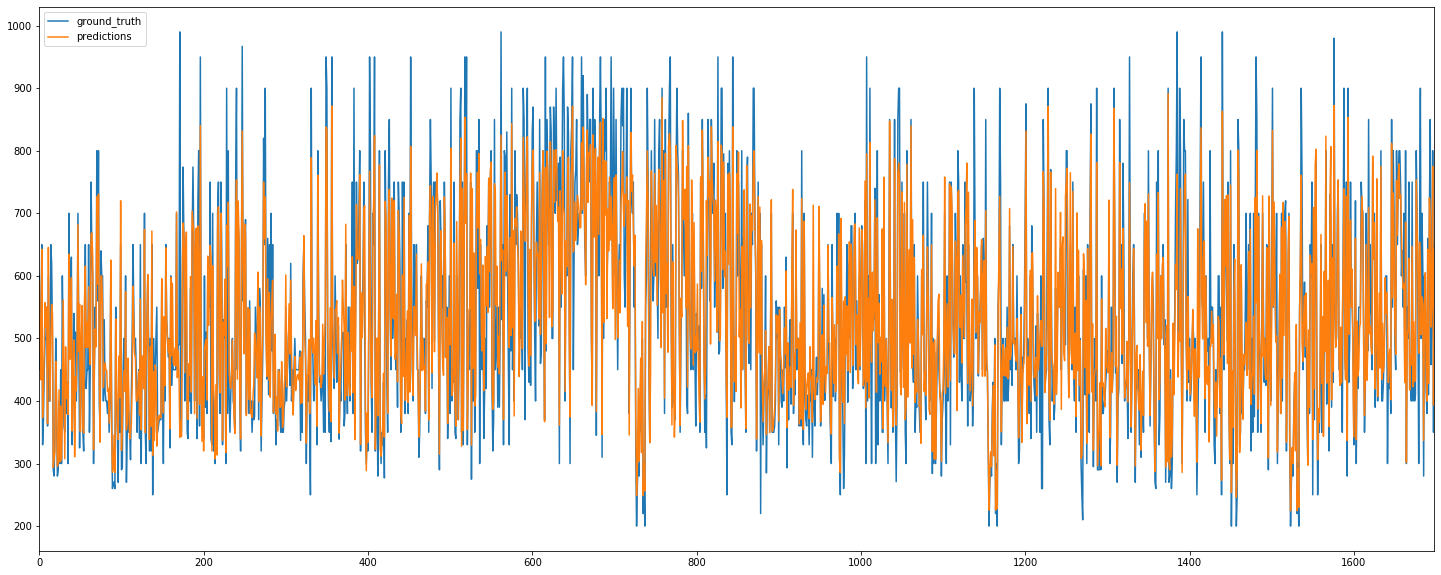

In [60]:
plt = confronto.plot(figsize=(25,10))
fig = plt.get_figure()
fig.savefig("risultato.png")
fig.savefig("risultato.svg")

In [61]:
from scipy.stats.stats import pearsonr

pearsonr(confronto['ground_truth'].values, confronto['predictions'].values)

(0.9086330103291136, 0.0)

In [62]:
diff = confronto['ground_truth']-confronto['predictions']

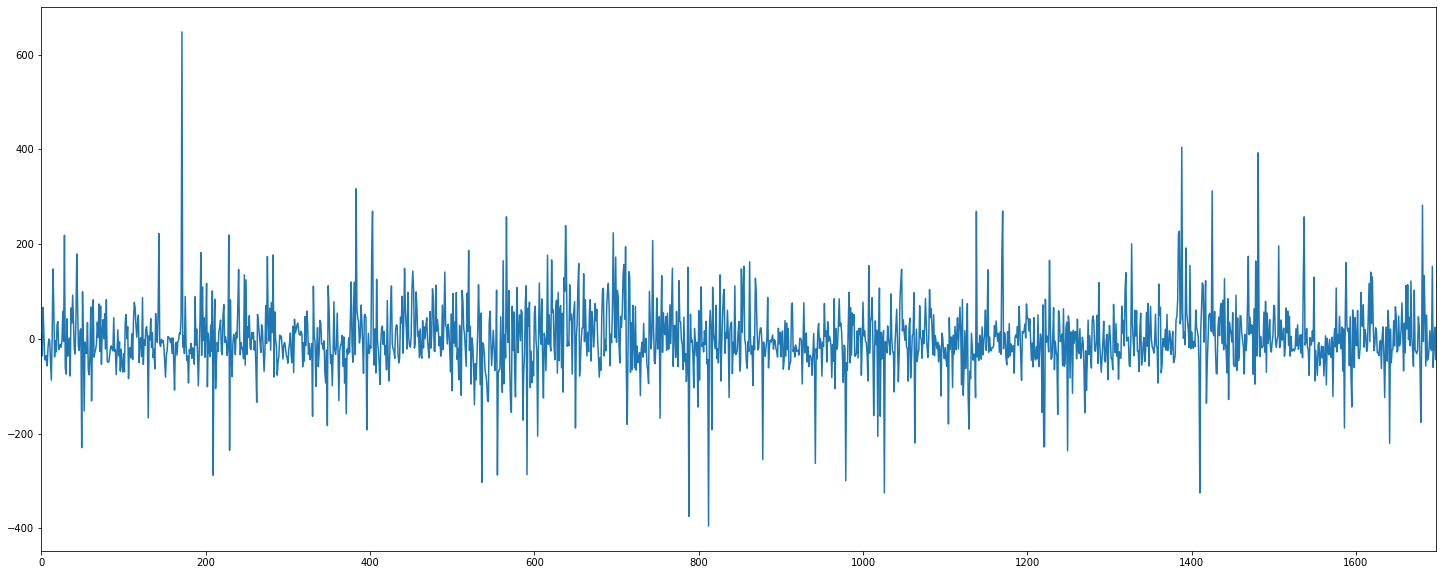

In [63]:
diff.plot(figsize=(25,10))

In [64]:
import pickle

with open('tpot_faster.pickle','wb') as xx:
    pickle.dump(tpot.fitted_pipeline_,xx)

In [65]:
import pickle

with open('tpot_faster.pickle', 'rb') as xx:
    model = pickle.load(xx)

In [66]:
my_dict = list(tpot.evaluated_individuals_.items())

model_scores = pd.DataFrame()
for model in my_dict:
    model_name = model[0]
    model_info = model[1]
    cv_score = model[1].get('internal_cv_score')  # Pull out cv_score as a column (i.e., sortable)
    model_scores = model_scores.append({'model': model_name,
                                        'cv_score': cv_score,
                                        'model_info': model_info,},
                                       ignore_index=True)

model_scores = model_scores.sort_values('cv_score', ascending=False)

In [78]:
with open('prediction_TPOT.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(flat_list)

## AUTOML

In [11]:
from sklearn.model_selection import train_test_split
from auto_ml import Predictor
from auto_ml.utils import get_boston_dataset
from auto_ml.utils_models import load_ml_model
from sklearn.model_selection import train_test_split
import pandas as pd


dataset = pd.read_csv('dataset_pre_allenamento.csv', sep=";")
dataset.drop(columns='Unnamed: 0', inplace=True)
dataset.fillna(0, inplace=True)

dataset['Price'] = dataset['Prezzo'].astype(int)
#dataset['Price'] = (dataset['Prezzo'].astype(int) + dataset['Spese condominio'].astype(int) + dataset['Spese riscaldamento'].astype(int))
dataset['Locali'] = dataset['Locali'].astype(int)
dataset = dataset[dataset['Price']<1000]
dataset.to_csv('dataset_minore_1000.csv', sep=';')
dati = dataset.drop(columns= ['Prezzo','Spese condominio', 'Spese riscaldamento'])

column_descriptions = {
    'Price': 'output',
    'Zona':'categorical',
    'Piano':'categorical',
    'Contratto':'categorical',
    'Tipologia':'categorical',
    'Tipo proprietà':'categorical',
    'Anno di costruzione':'categorical',
    'Stato':'categorical',
    'Riscaldamento':'categorical',
    'Climatizzatore':'categorical',
    'Classe energetica':'categorical',
    'Arredato S/N':'categorical'
}

df_train, df_test = train_test_split(dati,train_size=0.75, test_size=0.25)

ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)

ml_predictor.train(df_train)

# Score the model on test data
test_score = ml_predictor.score(df_test, df_test.Price)
test_modello = ml_predictor.save()
trained_model = load_ml_model(test_modello)

predictions = trained_model.predict(dati)
#print(predictions)

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'presort': False, 'learning_rate': 0.1, 'warm_start': True}
Running basic data cleaning
could not convert string to float: 'https://www.immobiliare.it/annunci/76783902/'
could not convert string to float: 'https://www.immobiliare.it/annunci/78579795/'
could not convert string to float: 'https://www.immobiliare.it/annunci/76410310/'
could not convert string to float: 'https://www.immobiliare.it/annunci/78160950/'
could not convert string to float: 'https://www.immobiliare.it/annunci/78000574/'
could not convert string to float: 'https://www.i

C:\Users\Francesco Manghi\Anaconda3\lib\site-packages\auto_ml\utils_data_cleaning.py:151: UserWarning: Consider marking the "Link annuncio" column as categorical
  warnings.warn('Consider marking the "{}" column as categorical'.format(key))


Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'presort': False, 'learning_rate': 0.1, 'warm_start': True}


********************************************************************************************
About to fit the pipeline for the model GradientBoostingRegressor to predict Price
Started at:
2020-01-27 17:28:57
[1] random_holdout_set_from_training_data's score is: -159.795
[2] random_holdout_set_from_training_data's score is: -152.892
[3] random_holdout_set_from_training_data's score is: -147.15
[4] random_holdout_set_from_training_data's score is: -142.137
[5] random_holdout_set_from_training_data's score is: -138.398
[6] random_holdout_set_from_training_data's score is: -134.414
[7] random_holdout_set_from_training_data's score is: -131.58
[8] random_holdout_set_from_training_data's score is: -128.918
[9] random_holdout_set

In [12]:
valutazione = pd.DataFrame()
ground_truth = dati['Price'].values
predictions = trained_model.predict(dati)
valutazione['Reale'] = ground_truth
valutazione['predictions'] = predictions
with open('predictions_AUTOML.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(predictions)

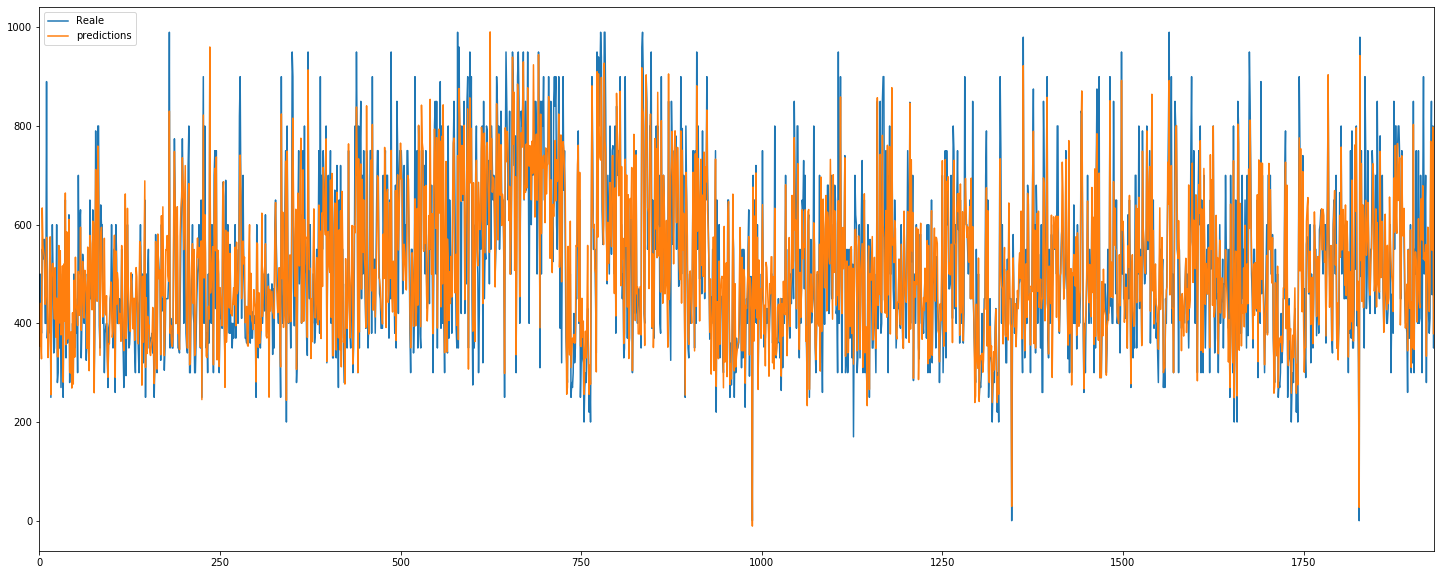

In [17]:
import matplotlib.pyplot as plot
plt = valutazione.plot(figsize=(25,10))
fig = plt.get_figure()
fig.savefig("risultato_automl.png")
fig.savefig("risultato_automl.svg")

In [14]:
from scipy.stats.stats import pearsonr

pearsonr(valutazione['Reale'].values, valutazione['predictions'].values)

(0.8853647453539442, 0.0)

80.15301460474677


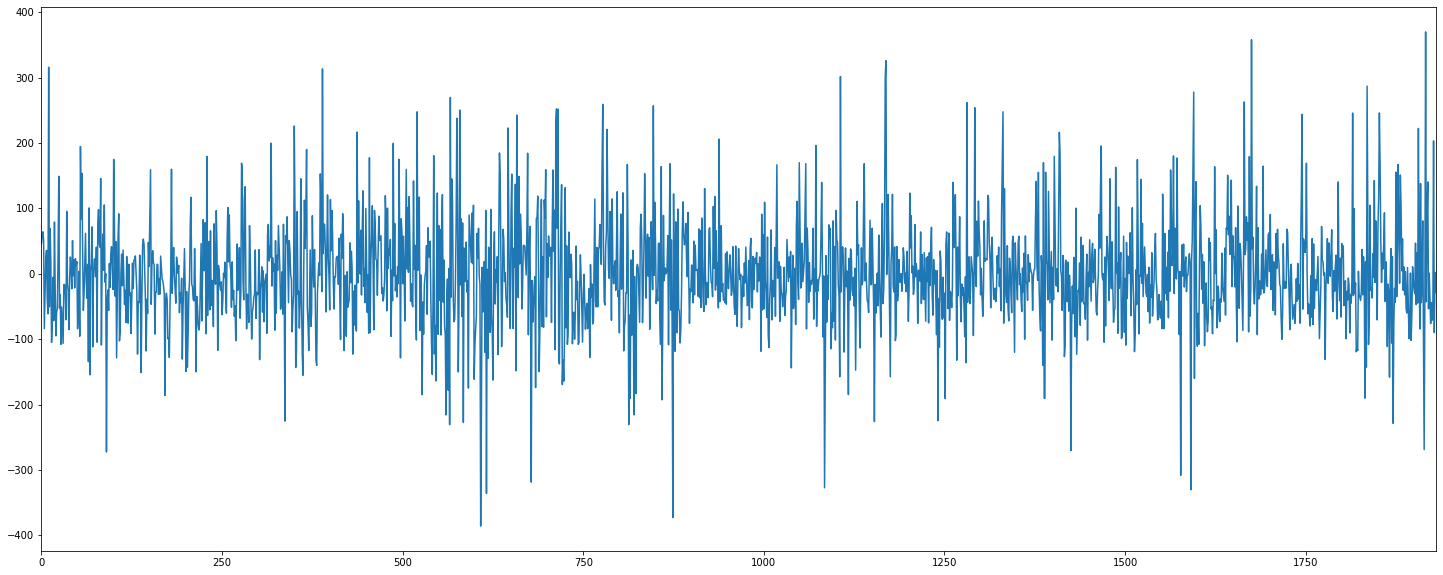

In [15]:
diff = valutazione['Reale']-valutazione['predictions']
print(diff.std())
diff.plot(figsize=(25,10))